# Clean light curves

The goals of this notebook are to: 

* Get light curves for analysis with STSP
 * read light curves from MAST
 * normalize each quarter of data by a 2nd order polynomial
* Measure the HAT-P-11 transit depth
 * identify transits that have the fewest/weakest starspot crossings
 * fit transit model to those most "spotless" transits
 * get a best depth measurement to use for STSP

### Open raw FITS files from MAST, clean out `nan`s

Save copies to `raw_long`, `raw_short` directories. 

In [20]:
#%load_ext autoreload
#%autoreload 2

import os
from glob import glob
import datacleaner
reload(datacleaner)
from datacleaner import LightCurve
import numpy as np

path_to_fits_files = '/local/tmp/hat11/010748390/'

# Retrieve long and short cadence data
long_cadence_paths = glob(os.path.join(path_to_fits_files, '*llc.fits'))
short_cadence_paths = glob(os.path.join(path_to_fits_files, '*slc.fits'))

long_lc = LightCurve.from_raw_fits(long_cadence_paths, name='raw_long')
short_lc = LightCurve.from_raw_fits(short_cadence_paths, name='raw_short')

data_path = '/astro/users/bmmorris/git/hat-11/data'
long_lc.save_to(data_path)
short_lc.save_to(data_path)

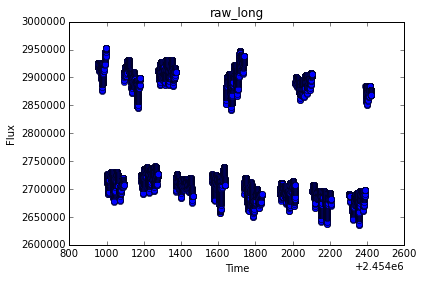

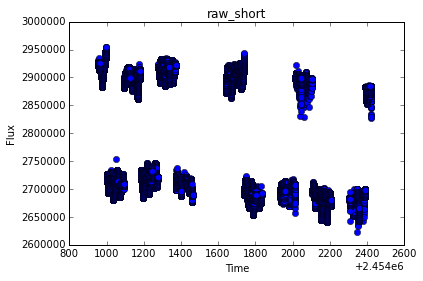

In [21]:
%matplotlib inline
long_lc.plot()
short_lc.plot()

### Normalize by quarter

For each quarter, fit a $O$(2) polynomial and divide the light curve by that polynomial. Save to `normalized_long` and `normalized_short`

/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2

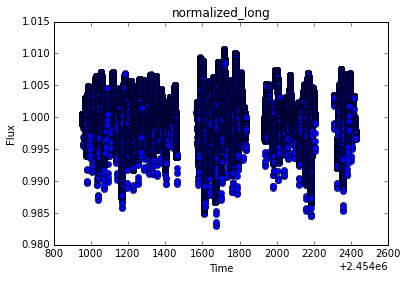

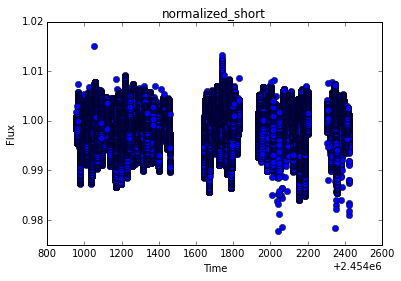

In [22]:
# Fit 2nd order polynomial to each quarter, divide to normalize
long_lc.normalize_each_quarter(rename='normalized_long')
short_lc.normalize_each_quarter(rename='normalized_short')

# Plot results, save
long_lc.plot()
short_lc.plot()

long_lc.save_to(data_path)
short_lc.save_to(data_path)

### Break out individual transits

Separate light curve into individual transits by masking out the out-of-transit portions of the light curve and separating the big `LightCurve` object into lots of little `TransitLightCurve` objects.

Then fit the out-of-transit portions of each transti for a linear baseline trend, and divide it out.

In [23]:
from datacleaner import LightCurve
short_transits = LightCurve(name='transits_short', **short_lc.mask_out_of_transit())
short_transits.save_to(data_path, overwrite=True)
transits = short_transits.get_transit_light_curves()
for transit in transits:
    transit.remove_linear_baseline()

(0.02819474873586687, 0.00068111903965473175, 2.4439009)


### Identify "spotless" transits

* do rough model fit to each transit with `scipy.optimize.fmin` including only a few transit parameters ($R_p/R_s$, $a/R_s$, $i$, $t_0$)
* Measure $\chi^2$ for best-fit model
 
**Hypothesis**: $\chi^2$ can be used as a proxy for inverse starspot-importance in each transit. Transits with low $\chi^2$ are well-described by a simple transit model, which implies they have few spot crossings. 

In [24]:
# Warning: this step fits each transit in the short cadence data and is slow (~2 min)
import os
chi2_file_path = 'chi2.npy'
if not os.path.exists(chi2_file_path):
    chi2 = np.array([transit.fiducial_transit_fit()[1] for transit in transits])
    np.save(chi2_file_path, chi2)
else:
    chi2 = np.load(chi2_file_path)

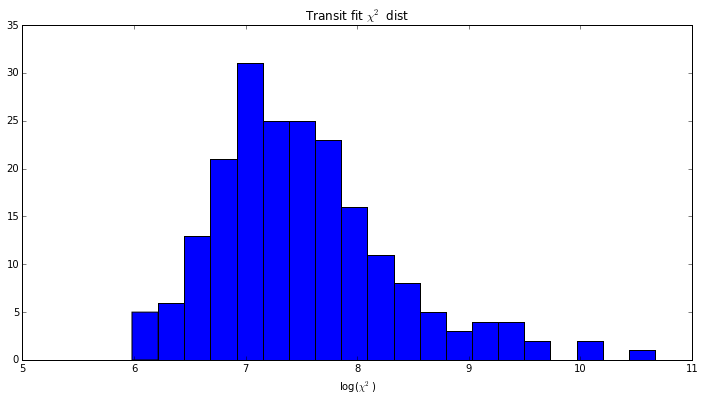

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(np.log(chi2), 20)
ax.set(xlabel=r'log($\chi^2$)', title=r'Transit fit $\chi^2$ dist')
plt.show()

The distribution of $\chi^2$ shows that there's a long tail of poor fits to the data, and a handful of very good fits. The handful of very good fits all have $\log{\chi^2} < 6.5$. Any higher than 6.5 and there are readily visible spot-crossings in the transit. Now filter out only these transits with $\log{\chi^2} < 6.5$ for detailed transit analysis.

### Combine "spotless" light curves, fit model

In [26]:
chi2 = []
depths = []
for transit in transits:
    p, chi = transit.fiducial_transit_fit()
    depths.append(p[1])
    chi2.append(chi)

# spotless transits: 3


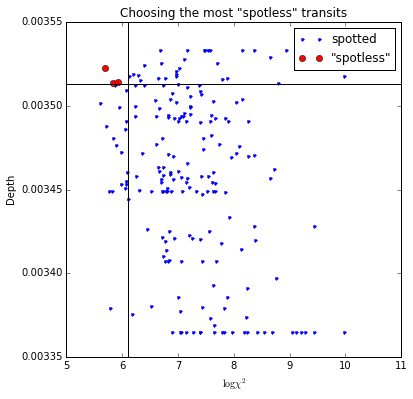

In [45]:
chi2_threshold = 6.1
depth_threshold = 0.003513
reload(datacleaner)
from datacleaner import concatenate_transit_light_curves
spotless_transit_inds = (np.log(chi2) < chi2_threshold) * (np.array(depths) > depth_threshold)
spotless_transits = concatenate_transit_light_curves([transit for i, transit in enumerate(transits) 
                                                      if spotless_transit_inds[i]], name='spotless_transits')
spotless_transits.save_to(data_path, overwrite=True)

print('# spotless transits: {}'.format(np.count_nonzero(spotless_transit_inds)))
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(np.log(chi2), depths, '.', label='spotted')
ax.plot(np.log(chi2)[spotless_transit_inds], 
        np.array(depths)[spotless_transit_inds], 'ro', label='"spotless"')

ax.axvline(chi2_threshold, color='k')
ax.axhline(depth_threshold, color='k')
ax.legend(loc='upper right')
ax.set_ylim([0.00335, 0.00355])
ax.set(xlabel=r'$\log{\chi^2}$', ylabel=r'Depth', 
       title='Choosing the most "spotless" transits');

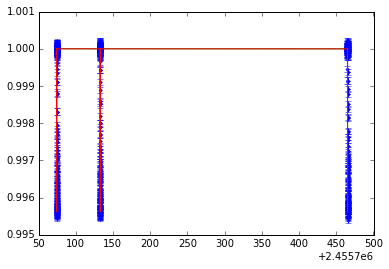

In [46]:
leastsq_fit_params, chi2_spotless = spotless_transits.fiducial_transit_fit(plots=True)

### Use `emcee` to get PDFs for interesting transit parameters

Here I'm fitting for: $t_0$, depth, duration, impact parameter and Kipping's efficient two-parameter limb-darkening terms $q_1$, $q_2$.

In [51]:
import cleanfit
reload(cleanfit)
from cleanfit import run_emcee, plot_triangle

# Use least-sq results and Deming 2011 params to start MCMC
[t0, depth, dur, b] = leastsq_fit_params
[q1, q2] = [0.518, 0.426] # Claret -> Kipping
p0 = [t0, depth, dur, b, q1, q2]
n_steps = 2000
scale_the_errors_by_a_factor_of = 1.0
transit_lc = spotless_transits
# n_steps=1000 Takes about ~3 min
samples, sampler = run_emcee(p0, transit_lc.times.jd, transit_lc.fluxes, 
                             scale_the_errors_by_a_factor_of*transit_lc.errors, 
                             n_steps)

accept frac = 0.44006875


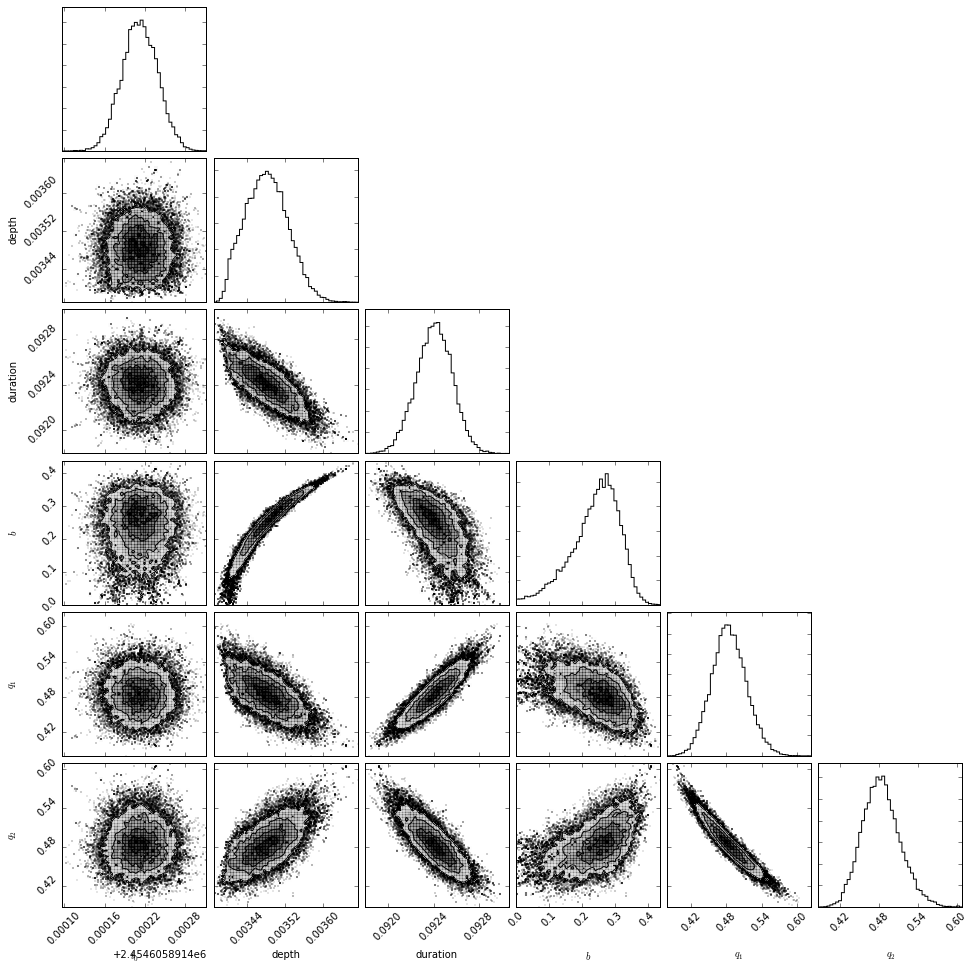

In [52]:
reload(cleanfit)
from cleanfit import run_emcee, plot_triangle
print("accept frac = {}".format(np.mean(sampler.acceptance_fraction)))
plot_triangle(samples[:-1000, :])

### Find mode of depth posterior (quadratic LD)

A priori, it's unclear if this will be tricky or not. If there are starspot-crossings even in this "spotless" set of transits, then the depth posterior should be skewed towards shallower depths.

To quantify the affect of spots skewing the depth posterior, I'll fit the depth posterior twice to look for asymmetry -- once on only the deepest half of the posterior, the other time on the whole posterior.

Best-fit depth, right-half only: 0.003478 ± 0.000047
Best-fit depth, whole dist.: 0.003479 ± 0.000047


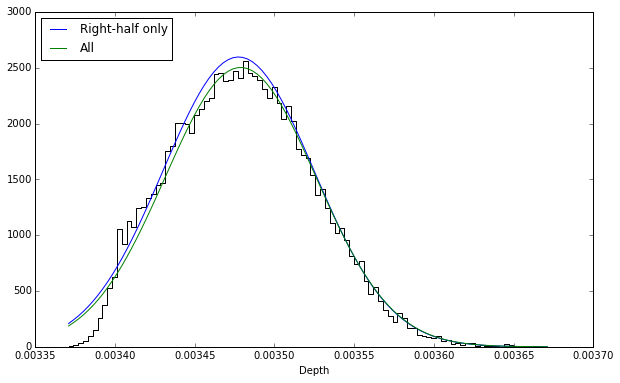

In [54]:
depth_chain = samples[:,1]
n, edges = np.histogram(depth_chain, 100)
bin_centers = 0.5*(edges[1:] + edges[:-1])

depth_mode_fit_limit = 0.0035
below_mode = bin_centers > depth_mode_fit_limit

from scipy import optimize
def gaussian(x, x0, sigma, amp):
    return amp*np.exp(-0.5*(x-x0)**2/sigma**2)

def fit_gaussian(params, x, y, yerr):
    return (gaussian(x, *params) - y)/yerr

initp = [depth_mode_fit_limit, 0.00002, 1100]

p_righthalfonly = optimize.leastsq(fit_gaussian, initp, 
                                  args=(bin_centers[below_mode], n[below_mode], 0.05*np.max(n[below_mode])),
                                  diag=(1./bin_centers[below_mode].mean(), 1./n[below_mode].mean()))


p_all = optimize.leastsq(fit_gaussian, initp, 
                         args=(bin_centers, n, 0.05*np.max(n)),
                         diag=(1./bin_centers.mean(), 1./n.mean()))

print("Best-fit depth, right-half only: {:.6f} ± {:.6f}".format(*p_righthalfonly[0][0:2]))
print("Best-fit depth, whole dist.: {:.6f} ± {:.6f}".format(*p_all[0][0:2]))

fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(bin_centers, n, ls='steps', color='k')
ax.plot(bin_centers, gaussian(bin_centers, *p_righthalfonly[0]), label='Right-half only')
ax.plot(bin_centers, gaussian(bin_centers, *p_all[0]), label='All')
ax.set(xlabel='Depth')
ax.legend(loc='upper left')
plt.show()


Since the posterior doesn't seem to be significantly weighted towards positive or negative deviations from the mode, let's just assume that the depth posterior is gaussian and use that depth and uncertainties.

In [71]:
results = np.percentile(depth_chain, [16, 50, 84])
median = results[1]
lower = results[1]-results[0]
upper = results[2]-results[1]
result_str = r"\text{{Depth}} = {{{median:.6f}}}_{{-{upper:.6f}}}^{{+{lower:.6f}}}".format(**locals())
from IPython.display import display, Math
print("Quadratic limb darkening:")
display(Math(result_str))

Quadratic limb darkening:


<IPython.core.display.Math object>

### Find mode of depth posterior (nonlinear LD)

In [63]:
import cleanfit
reload(cleanfit)
from cleanfit import run_emcee, plot_triangle

# Use least-sq results and Deming 2011 params to start MCMC
[t0, depth, dur, b] = leastsq_fit_params
#[q1, q2] = [0.518, 0.426] # Claret -> Kipping
p0 = [t0, depth, dur, b, 0.4, 0.3, 0.01, 0.05]
n_steps = 2000
scale_the_errors_by_a_factor_of = 1.0
transit_lc = spotless_transits
# n_steps=1000 Takes about ~3 min
samples_4param, sampler_4param = run_emcee(p0, transit_lc.times.jd, transit_lc.fluxes, 
                                           scale_the_errors_by_a_factor_of*transit_lc.errors, 
                                           n_steps)

accept frac = 0.3817


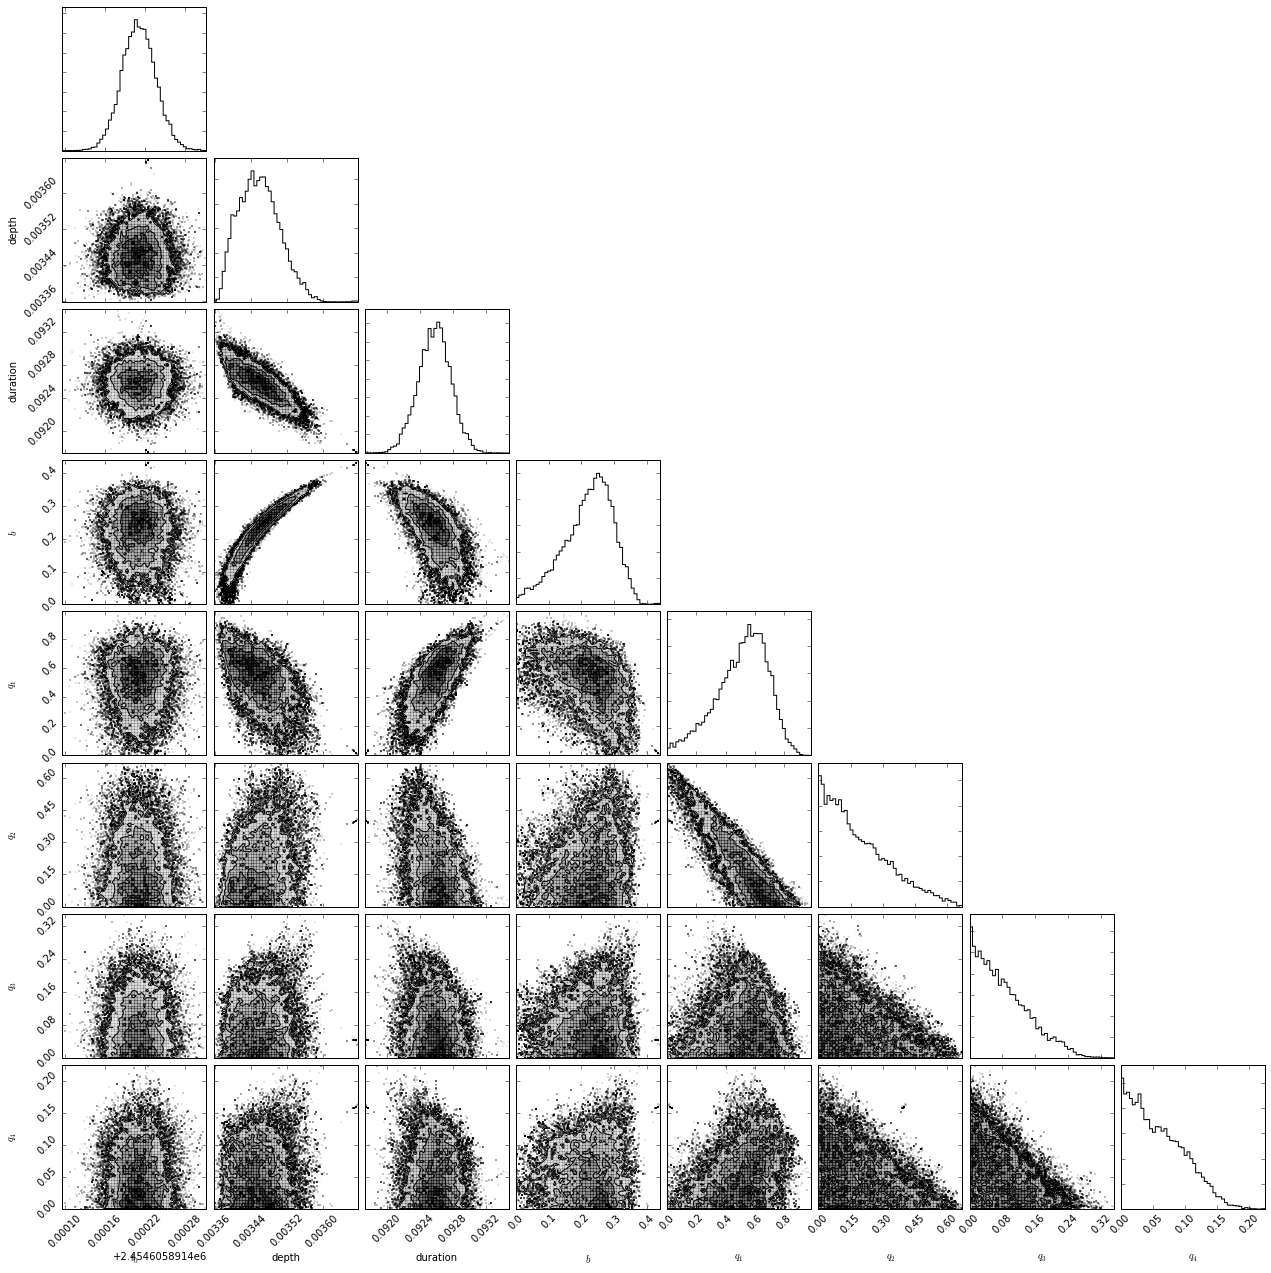

In [66]:
reload(cleanfit)
from cleanfit import plot_triangle
print("accept frac = {}".format(np.mean(sampler.acceptance_fraction)))
plot_triangle(samples_4param[:, :])

Best-fit depth, right-half only: 0.003460 ± 0.000047
Best-fit depth, whole dist.: 0.003455 ± 0.000048


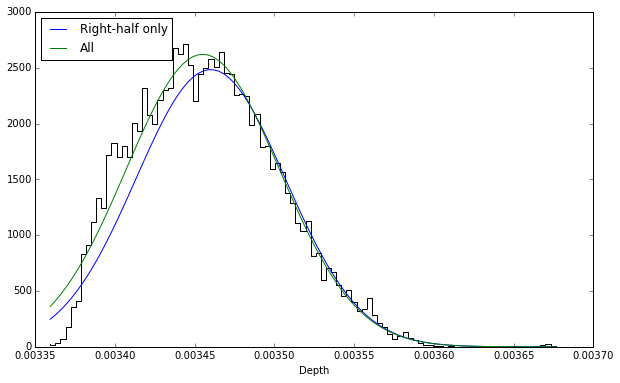

Nonlinear limb darkening:


<IPython.core.display.Math object>

In [70]:

depth_chain_4param = samples_4param[:,1]
n, edges = np.histogram(depth_chain_4param, 100)
bin_centers = 0.5*(edges[1:] + edges[:-1])

depth_mode_fit_limit = 0.00345
below_mode = bin_centers > depth_mode_fit_limit

from scipy import optimize
def gaussian(x, x0, sigma, amp):
    return amp*np.exp(-0.5*(x-x0)**2/sigma**2)

def fit_gaussian(params, x, y, yerr):
    return (gaussian(x, *params) - y)/yerr

initp = [depth_mode_fit_limit, 0.00002, 1100]

p_righthalfonly = optimize.leastsq(fit_gaussian, initp, 
                                  args=(bin_centers[below_mode], n[below_mode], 0.05*np.max(n[below_mode])),
                                  diag=(1./bin_centers[below_mode].mean(), 1./n[below_mode].mean()))


p_all = optimize.leastsq(fit_gaussian, initp, 
                         args=(bin_centers, n, 0.05*np.max(n)),
                         diag=(1./bin_centers.mean(), 1./n.mean()))

print("Best-fit depth, right-half only: {:.6f} ± {:.6f}".format(*p_righthalfonly[0][0:2]))
print("Best-fit depth, whole dist.: {:.6f} ± {:.6f}".format(*p_all[0][0:2]))

fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(bin_centers, n, ls='steps', color='k')
ax.plot(bin_centers, gaussian(bin_centers, *p_righthalfonly[0]), label='Right-half only')
ax.plot(bin_centers, gaussian(bin_centers, *p_all[0]), label='All')
ax.set(xlabel='Depth')
ax.legend(loc='upper left')
plt.show()

results = np.percentile(depth_chain_4param, [16, 50, 84])
median = results[1]
lower = results[1]-results[0]
upper = results[2]-results[1]
result_str = r"\text{{Depth}} = {{{median:.6f}}}_{{-{upper:.6f}}}^{{+{lower:.6f}}}".format(**locals())
from IPython.display import display, Math
print('Nonlinear limb darkening:')
display(Math(result_str))